In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [5]:
data_directory = r'C:\Users\harin\OneDrive\Desktop\dataset'
images_directory = os.path.join(data_directory, r'images')
masks_directory = os.path.join(data_directory, r'masks')

In [6]:
images_walk_data = list(os.walk(images_directory))
masks_walk_data = list(os.walk(masks_directory))

In [8]:
imagesfilenames = images_walk_data[0][2]
masksfilenames = [i[:-4]+'.png' for i in imagesfilenames]

In [9]:
# imagesfilenames = [i for i in imagesfilenames if 'open_circuit' in i]
# masksfilenames = [i[:-4]+'.png' for i in imagesfilenames]

In [10]:
len(imagesfilenames)

693

In [11]:
images_filepaths = [os.path.join(images_walk_data[0][0], i) for i in imagesfilenames]
masks_filepaths = [os.path.join(masks_walk_data[0][0], i) for i in masksfilenames]

In [13]:
imagesfilenames[5]

'01_missing_hole_06.jpg'

In [22]:
image = np.array(Image.open(masks_filepaths[0]))
number_of_images = len(imagesfilenames)
number_of_pixels = image.size

In [25]:
# # input_shape = (1586, 3034)
# #input_shape = (352, 640)
# input_shape = (480, 352)
# number_of_output_neurons = number_of_pixels
# number_of_input_neurons = number_of_pixels*1



In [27]:
# x = np.zeros((number_of_images, *input_shape, 1))
# y = np.zeros((number_of_images, *input_shape))

In [29]:
# for i in range(number_of_images):
#     image = np.array(Image.open(images_filepaths[i]).convert('L').resize(input_shape, Image.Resampling.LANCZOS)).reshape((*input_shape,1))
#     x[i,:] = image/255
#     mask = np.array(Image.open(masks_filepaths[i]).convert('L').resize(input_shape, Image.Resampling.LANCZOS)).reshape((input_shape))
#     y[i,:] = mask/255

In [31]:
input_shape = (480, 352, 3)
input_shape_numpy = (input_shape[1], input_shape[0], 3)
number_of_pixels = np.prod(input_shape)
number_of_output_neurons = number_of_pixels

n_augmentation = 2

In [34]:
X = np.zeros((n_augmentation*number_of_images, *input_shape_numpy))
y = np.zeros((n_augmentation*number_of_images, *input_shape_numpy[:2]))

In [37]:

for i in range(number_of_images):
    ind = n_augmentation*i
    image = Image.open(images_filepaths[i]).resize(input_shape[:2], Image.Resampling.LANCZOS)
    mask = Image.open(masks_filepaths[i]).resize(input_shape[:2], Image.Resampling.LANCZOS)
    X[ind,:] = np.array(image)/255
    X[ind+1,:] = np.array(image.transpose(Image.FLIP_LEFT_RIGHT))/255
    y[ind,:] = np.array(mask)/255
    y[ind+1,:] = np.array(mask.transpose(Image.FLIP_LEFT_RIGHT))/255


In [38]:
y[y < 0.5] = 0
y[y >= 0.5] = 1

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
def iou_value(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    iou = intersection / (union + K.epsilon())
    return iou

def accuracy_value(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_pred_f = tf.round(y_pred_f)
    correct_preds = tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32)
    accuracy = tf.reduce_mean(correct_preds)
    return accuracy

# def double_conv_block(x, n_filters):
#     x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#     x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#     return x

# def double_conv_block(x, n_filters):
#     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
#     x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization added
#     x = tf.keras.layers.Activation("relu")(x)

#     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
#     x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization added
#     x = tf.keras.layers.Activation("relu")(x)
#     return x


def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def downsample_block(x, n_filters, d):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(d)(p)
    return f, p

def upsample_block(x, conv_features, n_filters, d):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

    # # Apply attention gate
    # attn_g = attention_gate(conv_features, x, n_filters, n_filters * 2)

    # x = tf.keras.layers.concatenate([attn_g, x])  # Concatenate attention-weighted features

    x = tf.keras.layers.concatenate([conv_features, x])

    x = tf.keras.layers.Dropout(d)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(input_image_shape, n, d):
    inputs = tf.keras.layers.Input(shape=input_image_shape)

    f1, p1 = downsample_block(inputs, 16*n, d)
    f2, p2 = downsample_block(p1, 32*n, d)
    f3, p3 = downsample_block(p2, 64*n, d)
    f4, p4 = downsample_block(p3, 128*n, d)

    bottleneck = double_conv_block(p4, 256*n)

    u6 = upsample_block(bottleneck, f4, 128*n, d)
    u7 = upsample_block(u6, f3, 64*n, d)
    u8 = upsample_block(u7, f2, 32*n, d)
    u9 = upsample_block(u8, f1, 16*n, d)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net_with_Attention_Gate")
    return unet_model

def attention_gate(x, g, in_channels, gate_channels, inter_channels=None, sub_sample_factor=(2, 2)):
    if inter_channels is None:
        inter_channels = in_channels // 2

    W_g = tf.keras.Sequential([
        tf.keras.layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization()
    ])(g)

    W_x = tf.keras.Sequential([
        tf.keras.layers.Conv2D(inter_channels, kernel_size=1, strides=sub_sample_factor, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization()
    ])(x)

    # Upsample W_x to match the spatial dimensions of W_g
    W_x = tf.keras.layers.UpSampling2D(size=sub_sample_factor, interpolation='bilinear')(W_x)

    psi = tf.keras.layers.ReLU()(tf.keras.layers.Add()([W_g, W_x]))
    psi = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, padding='same', use_bias=False)(psi)
    psi = tf.keras.layers.BatchNormalization()(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)

    return tf.keras.layers.Multiply()([x, psi])

def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

model = build_unet_model(input_shape_numpy, 2,0.3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=dice_loss,
    metrics=[accuracy_value, 'Precision', 'Recall', iou_value]
)

model = tf.keras.models.load_model('unet.keras', custom_objects={'dice_loss': dice_loss, 'accuracy_value': accuracy_value, 'iou_value': iou_value})



In [41]:
i = 901

In [42]:
if i%2 == 0:
    print('File name:',imagesfilenames[int(i/2)])
else:
    print('File name:',imagesfilenames[int(np.floor(i/2))])

File name: 08_open_circuit_10.jpg


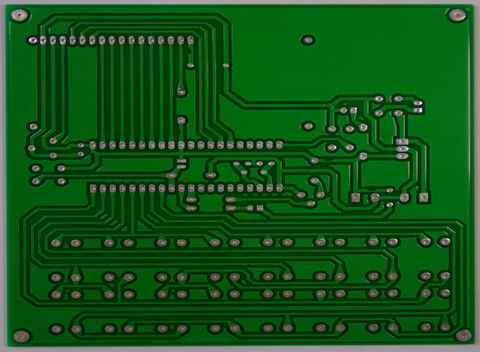

In [43]:
Image.fromarray(np.uint8(X_train[i]*255))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


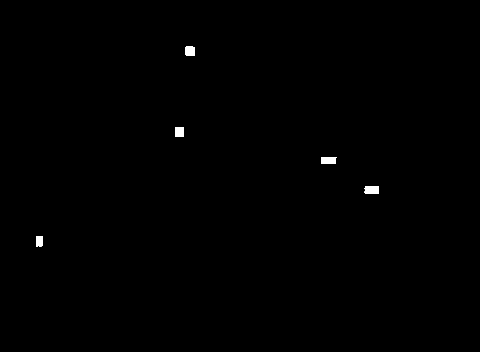

In [44]:
Image.fromarray(np.uint8(255*model.predict(X_train[i:i+1])[0,:,:,0]))

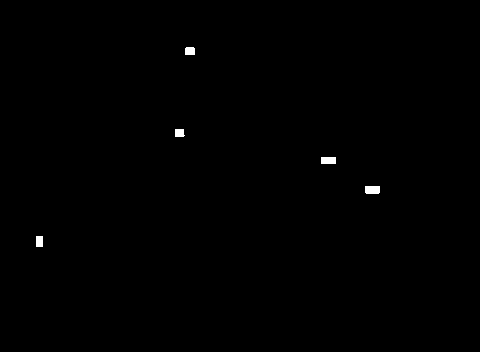

In [45]:
Image.fromarray(np.uint8(255*y_train[i:i+1])[0,:,:])

In [ ]:
# def iou_value(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     y_true_f = tf.cast(y_true_f, tf.float32)
#     y_pred_f = tf.cast(y_pred_f, tf.float32)

#     intersection = K.sum(y_true_f * y_pred_f)
#     union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

#     iou = intersection / (union + K.epsilon())
#     return iou

# def accuracy_value(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     y_pred_f = tf.round(y_pred_f)
#     correct_preds = tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32)
#     accuracy = tf.reduce_mean(correct_preds)
#     return accuracy

# # def double_conv_block(x, n_filters):
# #     x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
# #     x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
# #     return x

# # def double_conv_block(x, n_filters):
# #     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
# #     x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization added
# #     x = tf.keras.layers.Activation("relu")(x)

# #     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
# #     x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization added
# #     x = tf.keras.layers.Activation("relu")(x)
# #     return x


# def double_conv_block(x, n_filters):
#     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)

#     x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
#     return x

# def downsample_block(x, n_filters, d):
#     f = double_conv_block(x, n_filters)
#     p = tf.keras.layers.MaxPool2D(2)(f)
#     p = tf.keras.layers.Dropout(d)(p)
#     return f, p

# def upsample_block(x, conv_features, n_filters, d):
#     x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

#     # # Apply attention gate
#     # attn_g = attention_gate(conv_features, x, n_filters, n_filters * 2)

#     # x = tf.keras.layers.concatenate([attn_g, x])  # Concatenate attention-weighted features

#     x = tf.keras.layers.concatenate([conv_features, x])

#     x = tf.keras.layers.Dropout(d)(x)
#     x = double_conv_block(x, n_filters)
#     return x

# def build_unet_model(input_image_shape, n, d):
#     inputs = tf.keras.layers.Input(shape=input_image_shape)

#     f1, p1 = downsample_block(inputs, 16*n, d)
#     f2, p2 = downsample_block(p1, 32*n, d)
#     f3, p3 = downsample_block(p2, 64*n, d)
#     f4, p4 = downsample_block(p3, 128*n, d)

#     bottleneck = double_conv_block(p4, 256*n)

#     u6 = upsample_block(bottleneck, f4, 128*n, d)
#     u7 = upsample_block(u6, f3, 64*n, d)
#     u8 = upsample_block(u7, f2, 32*n, d)
#     u9 = upsample_block(u8, f1, 16*n, d)

#     outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

#     unet_model = tf.keras.Model(inputs, outputs, name="U-Net_with_Attention_Gate")
#     return unet_model

# def attention_gate(x, g, in_channels, gate_channels, inter_channels=None, sub_sample_factor=(2, 2)):
#     if inter_channels is None:
#         inter_channels = in_channels // 2

#     W_g = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same', use_bias=False),
#         tf.keras.layers.BatchNormalization()
#     ])(g)

#     W_x = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(inter_channels, kernel_size=1, strides=sub_sample_factor, padding='same', use_bias=False),
#         tf.keras.layers.BatchNormalization()
#     ])(x)

#     # Upsample W_x to match the spatial dimensions of W_g
#     W_x = tf.keras.layers.UpSampling2D(size=sub_sample_factor, interpolation='bilinear')(W_x)

#     psi = tf.keras.layers.ReLU()(tf.keras.layers.Add()([W_g, W_x]))
#     psi = tf.keras.layers.Conv2D(1, kernel_size=1, strides=1, padding='same', use_bias=False)(psi)
#     psi = tf.keras.layers.BatchNormalization()(psi)
#     psi = tf.keras.layers.Activation('sigmoid')(psi)

#     return tf.keras.layers.Multiply()([x, psi])



In [ ]:
# def dice_loss(y_true, y_pred, smooth=1e-6):
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

In [ ]:
# model = build_unet_model(input_shape_numpy, 2,0.3)

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_value, 'Precision', 'Recall', iou_value])

In [ ]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=dice_loss,
#     metrics=[accuracy_value, 'Precision', 'Recall', iou_value]
# )

In [ ]:
# model = tf.keras.models.load_model("unet_model.keras", custom_objects={"accuracy_value": accuracy_value})

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# model = tf.keras.models.load_model('unet.keras', custom_objects={'dice_loss': dice_loss, 'accuracy_value': accuracy_value, 'iou_value': iou_value})

In [56]:
model.evaluate(X_train, y_train, batch_size=16)


70/70 ━━━━━━━━━━━━━━━━━━━━ 766s 11s/step - Precision: 0.9410 - Recall: 0.9441 - accuracy_value: 0.9996 - iou_value: 0.8916 - loss: 0.0575


[0.05630698800086975,
 0.9995772242546082,
 0.9392929673194885,
 0.9481745958328247,
 0.8935767412185669]

In [55]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 786s 85s/step - Precision: 0.9397 - Recall: 0.9500 - accuracy_value: 0.9996 - iou_value: 0.8956 - loss: 0.0552


[0.053559090942144394,
 0.9996044635772705,
 0.9419086575508118,
 0.950965940952301,
 0.8983075618743896]

In [ ]:
history = model.fit(X_train,y_train, epochs = 2000, batch_size=16)

Epoch 1/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 135s 914ms/step - Precision: 0.0065 - Recall: 0.3620 - accuracy_value: 0.7678 - iou_value: 0.0062 - loss: 0.9877
Epoch 2/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 505ms/step - Precision: 0.0069 - Recall: 0.0724 - accuracy_value: 0.9635 - iou_value: 0.0048 - loss: 0.9905
Epoch 3/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 505ms/step - Precision: 0.0119 - Recall: 0.1872 - accuracy_value: 0.9372 - iou_value: 0.0131 - loss: 0.9743
Epoch 4/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - Precision: 0.0701 - Recall: 0.0865 - accuracy_value: 0.9922 - iou_value: 0.0383 - loss: 0.9269
Epoch 5/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 504ms/step - Precision: 0.1857 - Recall: 0.1210 - accuracy_value: 0.9946 - iou_value: 0.0778 - loss: 0.8568
Epoch 6/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 502ms/step - Precision: 0.3179 - Recall: 0.1447 - accuracy_value: 0.9956 - iou_value: 0.1102 - loss: 0.8036
Epoch 7/2000
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 501ms/step - Precision: 0.4140 - Recall: 0.

KeyboardInterrupt: 